In [ ]:
# add your drive shortcut to your colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [ ]:
# import packages
import sys
import time

import numpy as np
import pandas as pd
from tqdm import tqdm

import nltk
import gensim
from textblob import Word
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
STOPWORD_LIST = stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# read data
default_path = r"/content/drive/MyDrive/FRE_GY_7043_Capstone_Project/Industry_Tags/"

In [ ]:
def get_data(path):
    """
    Read data: From work directory, from parquet to pandas dataframe
    Clean data: Concatenate all the columns of dataframe to a single column dataframe
        which is of concatenated string data type

    :param path: string; default file path
    :return: pd.DataFrame; pandas dataframe wrt features and labels (target)
    """
    # target/label
    dv = pd.read_parquet(path + 'data_vendor.parquet').rename(columns={'target': 'target_dv'})
    es = pd.read_parquet(path + 'enterprise_software.parquet').rename(columns={'target': 'target_es'})
    ft = pd.read_parquet(path + 'fintech.parquet').rename(columns={'target': 'target_ft'})

    # feature/text
    wb = pd.read_parquet(path + 'WebsiteTxt.parquet').set_index('domain_name')

    # extract and concatenate content_txt & website summary since they have most information
    df = wb[["content_txt", "website_summary"]]
    # df[df.isna()] = ' '  # set None to space, avoid invalid string concat
    # df.loc[:, 'feature'] = df['domain_name']
    # df.set_index('domain_name', inplace=True)
    # for col in df.columns:
    #     df['feature'] = df['feature'].str.cat(df[col], sep=' ')

    # feature is a concatenated str of content_txt and website summary
    df = df.fillna(' ')
    df['feature'] = df['content_txt'].str.cat(df['website_summary'], sep=' ')
    
    return pd.concat([df, dv, es, ft], axis=1).dropna()

In [ ]:
data = get_data(default_path)
data.head()

,content_txt,website_summary,feature,target_dv,target_es,target_ft
domain_name,,,,,,
thrivemarket.com,instructions how to enable javascript in your ...,"buy healthy food from top-selling, organic bra...",instructions how to enable javascript in your ...,0.0,0.0,0.0
madison-reed.com,for all shades of hair color shop now. home. g...,professional hair color and hair color product...,for all shades of hair color shop now. home. g...,0.0,0.0,0.0
beautycounter.com,skip to. your bag. skip to. navigation. skip t...,shop clean beauty and safer skin care for all ...,skip to. your bag. skip to. navigation. skip t...,0.0,0.0,0.0
swivelbeauty.com,about us. blog. search. stylist sign up. regis...,,about us. blog. search. stylist sign up. regis...,0.0,0.0,0.0
wantable.com,one more step. please complete the security ch...,,one more step. please complete the security ch...,0.0,0.0,0.0


In [ ]:
# preprocess data
def remove_special_characters(text):
    """
    Remove special characters
    Negative character set: [^xyz], [^\w\s]: 
        any character which is mot a word or space will be replaced by ''
    :param text: pd.Series of str; text
    :return: 
    """
    tqdm.pandas(desc=sys._getframe().f_code.co_name)
    return text.str.replace('[^\w\s]','')


def remove_common_words(text, top=10):
    """
    Remove common words
    Remove top 10 most frequent words
    :param text: pd.Series of str; text
    :param top: int; number of most frequent words we want to remove
    :return: 
    """
    tqdm.pandas(desc=sys._getframe().f_code.co_name)
    freq = pd.Series(' '.join(text).split()).value_counts()[:top]
    print(f"top {top} common words: {freq}.")
    return text.apply(lambda x: " ".join(x for x in x.split() if x not in freq.index))


def tokenise_text(text):
    """
    Tokenization by gensim simple preprocess
    This function removes punctuations, lowers cases, removes numbers
    :param text: pd.Series of str; text
    :return: generator
    """
    for sentence in text:
        # deacc=True removes punctuations
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))  


def remove_stopwords(text):
    """
    Remove stop words
    :param text: pd.Series of list; text
    :return: 
    """
    tqdm.pandas(desc=sys._getframe().f_code.co_name)
    return text.apply(lambda x: [w for w in x if w not in STOPWORD_LIST])


def lemmatise_text(text):
    """
    Lemmatise word in texts
    :param text: pd.Series of list; text
    :return: 
    """
    tqdm.pandas(desc=sys._getframe().f_code.co_name)
    return text.apply(lambda x: [Word(word).lemmatize() for word in x])


def normalise_text(text):
    """
    Integrated pipeline of text preprocessing
    :param text: pd.Series of str; text
    :return: 
    """
    text = remove_special_characters(text)
    text = remove_common_words(text)
    text = pd.Series(tokenise_text(text))
    text = remove_stopwords(text)
    text = lemmatise_text(text)
    return text


In [ ]:
print(data.shape)
for col in data.columns[:3]:
    print(f"average length of text in {col} is {np.mean([len(x.split(' ')) for x in data[col]])}")

(22987, 6)
average length of text in content_txt is 698.6111280288859
average length of text in website_summary is 17.1250271892809
average length of text in feature is 715.7361552181668


In [ ]:
# integrated text preprocessing pipeline
website_sum = normalise_text(data['website_summary'])
content_txt = normalise_text(data['content_txt'])
feature_cat = normalise_text(data['feature'])

top 10 common words: and     18322
the      9894
to       7697
for      7060
a        6069
of       5357
your     4676
in       4656
is       4586
with     4175
dtype: int64.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


top 10 common words: and     397078
the     367619
to      338353
a       201540
of      198343
for     157364
your    151243
in      147136
with    127639
our     117853
dtype: int64.
top 10 common words: and     415400
the     377513
to      346050
a       207609
of      203700
for     164424
your    155919
in      151792
with    131814
our     120450
dtype: int64.


In [ ]:
data.loc[:, 'website_sum_token'] = website_sum.values
data.loc[:, 'content_txt_token'] = content_txt.values
data.loc[:, 'feature_cat_token'] = feature_cat.values
data.head()

,content_txt,website_summary,feature,target_dv,target_es,target_ft,website_sum_token,content_txt_token,feature_cat_token
domain_name,,,,,,,,,
thrivemarket.com,instructions how to enable javascript in your ...,"buy healthy food from top-selling, organic bra...",instructions how to enable javascript in your ...,0.0,0.0,0.0,"[buy, healthy, food, topselling, organic, bran...","[instruction, enable, javascript, web, browser...","[instruction, enable, javascript, web, browser..."
madison-reed.com,for all shades of hair color shop now. home. g...,professional hair color and hair color product...,for all shades of hair color shop now. home. g...,0.0,0.0,0.0,"[professional, hair, color, hair, color, produ...","[shade, hair, color, shop, home, go, cart, hom...","[shade, hair, color, shop, home, go, cart, hom..."
beautycounter.com,skip to. your bag. skip to. navigation. skip t...,shop clean beauty and safer skin care for all ...,skip to. your bag. skip to. navigation. skip t...,0.0,0.0,0.0,"[shop, clean, beauty, safer, skin, care, skin,...","[skip, bag, skip, navigation, skip, main, cont...","[skip, bag, skip, navigation, skip, main, cont..."
swivelbeauty.com,about us. blog. search. stylist sign up. regis...,,about us. blog. search. stylist sign up. regis...,0.0,0.0,0.0,[],"[u, blog, search, stylist, sign, register, sig...","[u, blog, search, stylist, sign, register, sig..."
wantable.com,one more step. please complete the security ch...,,one more step. please complete the security ch...,0.0,0.0,0.0,[],"[one, step, please, complete, security, check,...","[one, step, please, complete, security, check,..."


In [ ]:
# data.to_csv(default_path + 'preprocessed_data.csv')

In [ ]:
# read data from Google Drive working directory
# data = pd.read_csv(default_path + 'preprocessed_data.csv')
# data.feature_cat_token

## Few Shot Learning Test

In [ ]:
# clone our few-shot repo
!git clone https://github.com/fastforwardlabs/few-shot-text-classification.git

Cloning into 'few-shot-text-classification'...
remote: Enumerating objects: 969, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 969 (delta 46), reused 37 (delta 37), pack-reused 914
Receiving objects: 100% (969/969), 122.66 MiB | 32.73 MiB/s, done.
Resolving deltas: 100% (611/611), done.


In [ ]:
!mv few-shot-text-classification/fewshot . 
!mv few-shot-text-classification/setup.py .
!mv few-shot-text-classification/data .

In [ ]:
!pip3 install datasets==1.1.2
!pip3 install transformers==3.3.0
!pip3 install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 7.0 MB/s 
     |████████████████████████████████| 69 kB 9.2 MB/s 
     |████████████████████████████████| 212 kB 66.2 MB/s 
     |████████████████████████████████| 115 kB 69.5 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.9 MB/s 
     |████████████████████████████████| 880 kB 60.4 MB/s 
     |████████████████████████████████| 1.2 MB 55.8 MB/s 
     |████████████████████████████████| 3.0 MB 56.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=9dd3042f058e6c6f19c867ec92d2b882356653c65f921169d94505cba359ba50
  Stored in directory: /root/.cache

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

from fewshot.data.loaders import (
    load_or_cache_data, 
    _load_agnews_dataset,
    _create_dataset_from_df
)

from fewshot.data.utils import select_subsample, expand_labels

from fewshot.embeddings.sentence_embeddings import (
    load_transformer_model_and_tokenizer,
    get_sentence_embeddings,
)

from fewshot.models.on_the_fly import OLS_with_l2_regularization

from fewshot.models.few_shot import (
    FewShotLinearRegression, 
    BayesianMSELoss,
    prepare_dataloader,
    train,
)   

from fewshot.eval import predict_and_score

from fewshot.utils import (
    fewshot_filename,
    torch_load,
    torch_save,
    pickle_load,
    pickle_save,
    to_tensor,
    to_list,
)


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
## Load SBERT embedding model
model, tokenizer = load_transformer_model_and_tokenizer("deepset/sentence_bert")

### Test on fintech label

In [ ]:
df_fintech = data[['target_ft', 'feature']].copy()
df_fintech.loc[:, 'category'] = np.where(df_fintech['target_ft'] == 1.0, 'Yes', 'No')
df_fintech = df_fintech.rename(columns={'target_ft': 'label', 'content_txt': 'text'})
df_fintech.head()

,label,feature,category
domain_name,,,
thrivemarket.com,0.0,instructions how to enable javascript in your ...,No
madison-reed.com,0.0,for all shades of hair color shop now. home. g...,No
beautycounter.com,0.0,skip to. your bag. skip to. navigation. skip t...,No
swivelbeauty.com,0.0,about us. blog. search. stylist sign up. regis...,No
wantable.com,0.0,one more step. please complete the security ch...,No


In [ ]:
print(f'length of positive samples {len(df_fintech[df_fintech.label == 1])}')
print(f'length of negative samples {len(df_fintech[df_fintech.label == 0])}')

length of positive samples 4397
length of negative samples 18590


In [ ]:
# Generate a subset containing 4000 examples for each category
df_fintech_subset = select_subsample(df_fintech, sample_size=4000, random_state=42)

# Split the sample in half -- 1000 for training, 1000 for validation
# df_fintech_train, df_fintech_valid, _, _ = train_test_split(
#     df_fintech_subset, 
#     df_fintech_subset['category'], 
#     test_size=.5, 
#     random_state=42, 
#     stratify=df_fintech_subset['category']
#     )

In [ ]:
print(f'length of positive samples {len(df_fintech_subset[df_fintech_subset.label == 1])}')
print(f'length of negative samples {len(df_fintech_subset[df_fintech_subset.label == 0])}')

length of positive samples 4000
length of negative samples 4000


In [ ]:
# df_fintech_train.head()

training sbert model on selected subsamples from train set, 100 subsamples for either neg or pos, total length: 200

In [ ]:
# Generate a subset from training DataFrame containing 100 examples for each category
df_fintech_train_100 = select_subsample(df_fintech_subset, sample_size=100)

# convert that DataFrame to a Dataset
fintech_train_100 = _create_dataset_from_df(df_fintech_train_100, 'feature')

# compute sbert embeddings for each example
fintech_train_100.calc_sbert_embeddings()

# this is required due the particular implementation details of our Dataset class
fintech_train_100 = expand_labels(fintech_train_100)

Computing sentence representations: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


In [ ]:
fintech_train_100.embeddings.shape

torch.Size([202, 768])

In [ ]:
# Test dataset would be the full train set
fintech_test = _create_dataset_from_df(df_fintech_subset, 'feature')

# compute sbert embeddings for each example
fintech_test.calc_sbert_embeddings()

# this is required due the particular implementation details of our Dataset class
fintech_test = expand_labels(fintech_test)

Computing sentence representations: 100%|██████████| 501/501 [03:46<00:00,  2.22it/s]


In [ ]:
fintech_test.examples[:5]

['request demo. name. required. your business email. required. product interest. required. conversation assistant. search assistant. whatsapp for business. message. optional. products. conversation assistant. automated call assistant. whatsapp for business. platform. prepackaged conversation modules. ai. inbox. analytics. channels. solutions. salons, spas med spas. dental clinics doctors offices. consumer product companies. small business front desk. enterprise help desk. resources. blog. case studies. company. products. conversation assistant. automated call assistant. whatsapp for business. platform. prepackaged conversation modules. ai. inbox. analytics. channels. solutions. salons, spas med spas. dental clinics doctors offices. consumer product companies. small business front desk. enterprise help desk. resources. blog. case studies. company. delight your customers with human-like automated conversations ai-powered automated conversations for your front desk and help desk to serve 

In [ ]:
fintech_test.embeddings.shape

torch.Size([8002, 768])

#### Calculate Zmap  
TODO: Train Zmap on our own corpus   
[Few Shot Learning: Zmap](https://github.com/fastforwardlabs/few-shot-text-classification/blob/master/notebooks/Zmap_Experiments.ipynb), it is using top 20k most frequent words to get vectors


In [ ]:
from keras.preprocessing.text import Tokenizer
import pickle
import gensim

In [ ]:
max_features = 2000
# tokenizer = Tokenizer(num_words=max_features)
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')  # lower=True
tokenizer.fit_on_texts(fintech_test.examples)
vocab = tokenizer.word_index

In [ ]:
len(vocab)

141886

In [ ]:
# Train zmap
# Sbert model on our own corpus
# Load SBERT embedding model
model, tokenizer = load_transformer_model_and_tokenizer("deepset/sentence_bert")

# Word2Vec model on our own corpus 
# Load W2V embedding model
embed_size = 768
w2v_model = gensim.models.Word2Vec(data['feature_cat_token'], size=embed_size, window=10, min_count=5, workers=10)
w2v_model.train(data['feature_cat_token'], total_examples=len(data['feature_cat_token']), epochs=10)
# Zmap_w2v = OLS_with_l2_regularization(sbert_vectors, to_tensor(w2v_vectors))

Computing sentence representations: 100%|██████████| 8868/8868 [1:10:24<00:00,  2.10it/s]


In [ ]:
w2v_vectors = np.zeros((len(vocab), embed_size)) # 从0开始计数 加1对应之前特征词
# create Word2Vec embedding for every word corresponding to its position embedding 
for word, i in vocab.items():
    try:
        # get word vector and create embedding matrix
        embedding_vector = w2v_model.wv[str(word)]
        w2v_vectors[i] = embedding_vector
    except KeyError: # pass if word not found
        continue

In [ ]:
# train sbert vectors on the same vocab
sbert_vectors = get_sentence_embeddings(
    vocab, 
    model, 
    tokenizer
    )

In [ ]:
Zmap_w2v = OLS_with_l2_regularization(sbert_vectors, to_tensor(w2v_vectors))

In [ ]:
# Load Zmap
Zmap_w2v = torch_load(fewshot_filename("data/maps", "Zmap_20k_w2v_words_alpha0.pt"))
Zmap_w2v.size()

torch.Size([768, 300])

In [ ]:
# convert the properly formatted training Dataset into a PyTorch DataLoader
data_loader = prepare_dataloader(fintech_train_100, Zmap_w2v)

#### Calculate Wmap

In [ ]:
# dimensions for Wmap should match the last dimension of Zmap since Wmap will modify SBERT*Zmap
model_size = (Zmap_w2v.size()[1], Zmap_w2v.size()[1])     
lr = 0.1          # learning rate
lam = 500         # lambda regularization value
epochs = 100      # training epochs
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# instantiate a model and loss function
fewshot_model = FewShotLinearRegression(
    *model_size, 
    loss_fcn=BayesianMSELoss(device=device), 
    lr=lr, 
    device=device)

# train
loss_history = train(fewshot_model, data_loader, num_epochs=epochs, lam=lam)

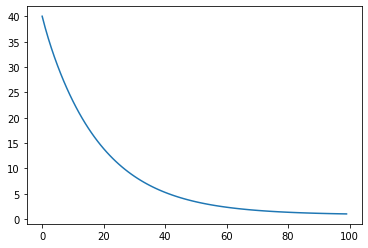

In [ ]:
# visualize the loss as a function of epochs
plt.plot(loss_history);

In [ ]:
# grab Wmap (weight matrix of the model)
Wmap_100 = fewshot_model.linear.weight.detach().cpu()

# predict on test set
test_score, ft_preds_test = predict_and_score(fintech_test, linear_maps=[Zmap_w2v, Wmap_100], return_predictions=True)

# predict on train set
train_score, ft_preds_train = predict_and_score(fintech_train_100, linear_maps=[Zmap_w2v, Wmap_100], return_predictions=True)
print(test_score, train_score)

71.275 76.0


In [ ]:
ft_preds_test[:5]

[Prediction(closest=[0, 1], scores=[0.3679269850254059, 0.3282959461212158], best=0),
 Prediction(closest=[1, 0], scores=[0.28872227668762207, 0.251669704914093], best=1),
 Prediction(closest=[0, 1], scores=[0.264237642288208, 0.14731718599796295], best=0),
 Prediction(closest=[0, 1], scores=[0.2006274312734604, 0.1441161185503006], best=0),
 Prediction(closest=[0, 1], scores=[0.356978178024292, 0.28751876950263977], best=0)]

In [ ]:
ft_preds_train[:5]

[Prediction(closest=[0, 1], scores=[0.38528284430503845, 0.26882779598236084], best=0),
 Prediction(closest=[0, 1], scores=[0.23794879019260406, 0.2300841510295868], best=0),
 Prediction(closest=[0, 1], scores=[0.3216497600078583, 0.21213291585445404], best=0),
 Prediction(closest=[0, 1], scores=[0.24354493618011475, 0.2120395302772522], best=0),
 Prediction(closest=[0, 1], scores=[0.13954082131385803, 0.027211258187890053], best=0)]

In [ ]:
from sklearn.metrics import f1_score
print(f'F1 Score on full data set: {f1_score(fintech_test.labels, [pred.best for pred in ft_preds_test])}')
print(f'F1 Score on train set: {f1_score(fintech_train_100.labels, [pred.best for pred in ft_preds_train])}')

F1 Score on full data set: 0.7495640802092415
F1 Score on train set: 0.7857142857142856


#### With fewer samples for fintech label
What if we only use 10 neg and 10 pos samples as few shot samples? Since customers will not be that patient if they need to read 200 sentences/text.

In [ ]:
# Generate a subset from training DataFrame containing 100 examples for each category
df_fintech_train_10 = select_subsample(df_fintech_subset, sample_size=10)

# convert that DataFrame to a Dataset
fintech_train_10 = _create_dataset_from_df(df_fintech_train_10, 'feature')

# compute sbert embeddings for each example
fintech_train_10.calc_sbert_embeddings()

# this is required due the particular implementation details of our Dataset class
fintech_train_10 = expand_labels(fintech_train_10)

Computing sentence representations: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


In [ ]:
fintech_train_10.embeddings.shape

torch.Size([22, 768])

In [ ]:
# convert the properly formatted training Dataset into a PyTorch DataLoader
data_loader = prepare_dataloader(fintech_train_10, Zmap_w2v)

# dimensions for Wmap should match the last dimension of Zmap since Wmap will modify SBERT*Zmap
model_size = (Zmap_w2v.size()[1], Zmap_w2v.size()[1])     
lr = 0.1          # learning rate
lam = 500        # lambda regularization value
epochs = 100      # training epochs
device = "cuda" if torch.cuda.is_available() else "cpu"

# instantiate a model and loss function
fewshot_model = FewShotLinearRegression(
    *model_size, 
    loss_fcn=BayesianMSELoss(device=device), 
    lr=lr, 
    device=device
    )

# train
loss_history = train(fewshot_model, data_loader, num_epochs=epochs, lam=lam)

# grab Wmap (weight matrix of the model)
Wmap_10 = fewshot_model.linear.weight.detach().cpu()

# predict on test set
test_score_10, ft_preds_test_10 = predict_and_score(fintech_test, linear_maps=[Zmap_w2v, Wmap_10], return_predictions=True)

# predict on train set
train_score_10, ft_preds_train_10 = predict_and_score(fintech_train_10, linear_maps=[Zmap_w2v, Wmap_10], return_predictions=True)
print(test_score_10, train_score_10)

65.1375 75.0


In [ ]:
print(f'F1 Score on full data set: {f1_score(fintech_test.labels, [pred.best for pred in ft_preds_test_10])}')
print(f'F1 Score on train set: {f1_score(fintech_train_10.labels, [pred.best for pred in ft_preds_train_10])}')

F1 Score on full data set: 0.6971440981648388
F1 Score on train set: 0.7826086956521738


Problem:   
1. the number of given labels is too small whereas the number of missing samples is too large = lower accuracy on testing set
2. Regularization = higher bias = lower accuracy on training set  

Improvement:
1. hyperparameter tuning 
2. predict part of label missing samples and perform few shot again on the rest data set 